## load data

In [4]:

import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split,StratifiedKFold
from sklearn.linear_model import LinearRegression,Ridge, RidgeCV,ElasticNet, ElasticNetCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score,precision_score, recall_score, f1_score, accuracy_score, roc_auc_score,roc_curve, auc

In [5]:
file_path = 'data/DataScientist_CaseStudy_Dataset.xlsx'
sheets_to_read = ['Soc_Dem', 'Products_ActBalance','Inflow_Outflow','Sales_Revenues']  

In [6]:
# Read all specified sheets into a dictionary of DataFrames
dataframes = pd.read_excel(file_path, sheet_name=sheets_to_read, engine='openpyxl')

In [7]:
df_demo = dataframes['Soc_Dem']
df_act = dataframes['Products_ActBalance']
df_flow = dataframes['Inflow_Outflow']
df_tar_rev = dataframes['Sales_Revenues']

In [8]:
print(df_demo.shape)
df_demo.head()

(1615, 4)


,Client,Sex,Age,Tenure
0,909,M,21,27
1,1217,M,38,165
2,850,F,49,44
3,1473,M,54,34
4,1038,M,29,106


In [9]:
print(df_act.shape)
df_act.head()

(1615, 13)


,Client,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,1,1,NaN,NaN,1.0,NaN,NaN,1333.802857,NaN,NaN,0.0,NaN,NaN
1,2,1,1.0,NaN,NaN,NaN,NaN,110.768571,13326.190357,NaN,NaN,NaN,NaN
2,3,1,NaN,1.0,NaN,NaN,NaN,482.654643,NaN,107.251786,NaN,NaN,NaN
3,4,1,1.0,NaN,NaN,1.0,NaN,1599.840714,76.437143,NaN,NaN,1110.381786,NaN
4,5,1,1.0,NaN,NaN,NaN,NaN,5353.483929,8079.715714,NaN,NaN,NaN,NaN


In [10]:
print(df_flow.shape)
df_flow.head()

(1587, 15)


,Client,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
0,1017,0.005000,0.005000,1,1,118.046429,118.046429,25.000000,91.796429,0.000000,12,12,2,9,0
1,1456,364.772143,364.752857,4,3,774.980000,774.980000,14.285714,497.444286,258.607143,28,28,1,20,5
2,545,2471.719286,2471.719286,14,14,2190.257143,2190.257143,303.571429,179.082143,1229.428571,23,23,3,5,12
3,667,1127.792857,1127.792857,4,4,1344.603571,1344.603571,642.857143,194.285714,249.321429,21,21,3,4,8
4,1381,571.618214,571.618214,3,3,57.071429,57.071429,10.714286,46.357143,0.000000,6,6,1,5,0


In [11]:
print(df_tar_rev.shape)
df_tar_rev.head()

(969, 7)


,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1094,0,1,0,0.000000,5.138571,0.0000
1,1484,1,0,1,25.609107,0.000000,8.7225
2,20,0,1,0,0.000000,3.822500,0.0000
3,1193,0,0,0,0.000000,0.000000,0.0000
4,142,0,0,0,0.000000,0.000000,0.0000


In [12]:
duplicates_mask = df_demo.duplicated()
duplicate_rows = df_demo[duplicates_mask]
duplicate_rows #no duplicates

,Client,Sex,Age,Tenure


In [13]:
df_demo.duplicated().sum(),df_act.duplicated().sum(),df_flow.duplicated().sum(),df_tar_rev.duplicated().sum(),

(0, 0, 0, 0)

In [14]:
df_demo['Client'].duplicated().sum(),df_act['Client'].duplicated().sum(),df_flow['Client'].duplicated().sum(),df_tar_rev['Client'].duplicated().sum(),

(0, 0, 0, 0)

## merge

In [15]:
df_merged = df_demo.merge(df_act, how='left', on = 'Client').merge(df_flow, how='left', on = 'Client')

In [16]:
# df_merged[df_merged.Sex.isna()]
df_merged.Sex = df_merged.Sex.fillna('Unknown')

In [17]:
df_merged = df_merged.fillna(0)

In [18]:
# define columns for different transformations
count_cols = list(df_act.columns[df_act.columns.str.startswith('Count')])
amt_cols=list((df_act.columns[~df_act.columns.str.startswith('Count')].append(df_flow.columns)).drop('Client'))
target_cols= df_tar_rev.columns
target_cols = [x for x in target_cols if x not in ['Client']]

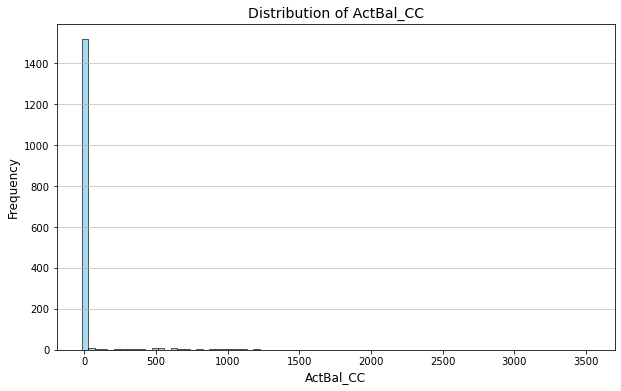

In [19]:
# col='Count_CL'
col='ActBal_CC'

plt.figure(figsize=(10, 6))
sns.histplot(df_merged[col], bins=80, kde=False, color='skyblue', edgecolor='black')
plt.title(f'Distribution of {col}', fontsize=14)
plt.xlabel(col, fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

In [20]:
amt_cols

['ActBal_CA',
 'ActBal_SA',
 'ActBal_MF',
 'ActBal_OVD',
 'ActBal_CC',
 'ActBal_CL',
 'VolumeCred',
 'VolumeCred_CA',
 'TransactionsCred',
 'TransactionsCred_CA',
 'VolumeDeb',
 'VolumeDeb_CA',
 'VolumeDebCash_Card',
 'VolumeDebCashless_Card',
 'VolumeDeb_PaymentOrder',
 'TransactionsDeb',
 'TransactionsDeb_CA',
 'TransactionsDebCash_Card',
 'TransactionsDebCashless_Card',
 'TransactionsDeb_PaymentOrder']

In [21]:
df_merged[amt_cols] = df_merged[amt_cols].clip(lower=0)

In [22]:
df_merged_tar=df_merged.merge(df_tar_rev, how='left', on = 'Client')
df_merged_tar.head()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,909,M,21,27,1,0.0,0.0,1.0,0.0,1.0,...,7.0,1.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1217,M,38,165,1,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,850,F,49,44,1,0.0,0.0,0.0,0.0,0.0,...,6.0,0.0,0.0,1.0,0.0,1.0,0.0,0.000000,0.893929,0.0
3,1473,M,54,34,1,1.0,0.0,0.0,1.0,1.0,...,38.0,1.0,26.0,11.0,1.0,0.0,0.0,4.929643,0.000000,0.0
4,1038,M,29,106,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


### log

In [23]:
log_colnames = []

for col in amt_cols: #+count_cols
    df_merged_tar[f'log_{col}'] = np.log1p(df_merged_tar[col])  # log(1+x) 
    log_colnames.append(f'log_{col}')

## train val test split

In [24]:
# separate those without sales info as test
df_train_total = df_merged_tar[~df_merged_tar.Sale_MF.isna()]
df_test = df_merged_tar[df_merged_tar.Sale_MF.isna()]

In [25]:
# further split train and validation
frac = 0.2  # Sample 20% of client IDs
val_ids = df_train_total['Client'].sample(frac=frac, random_state=42)
train_ids = list(set(df_train_total['Client']) - set(val_ids))
print(len(val_ids),len(train_ids))

194 775


In [26]:
# split train validation by client id
df_train=df_train_total[df_train_total.Client.isin(train_ids)]
df_val=df_train_total[df_train_total.Client.isin(val_ids)]

In [27]:
# keep a copy of validation client id
df_val_client=df_val[['Client']]

## Feature engineering

### one hot

In [28]:
# define columns and path to save encoder
cols_ohe = ['Sex']
enc_dir = 'encoders/'
os.makedirs(enc_dir, exist_ok=True)
    
encoder_path = os.path.join(enc_dir, "onehot_encoder.joblib")
print(encoder_path)

encoders/onehot_encoder.joblib


In [29]:
# fit encoder, handle_unknown='ignore' in case of unseen category in test data
ohe = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
X_train_cat_enc = ohe.fit_transform(df_train[cols_ohe])
X_val_cat_enc = ohe.transform(df_val[cols_ohe])
X_test_cat_enc = ohe.transform(df_test[cols_ohe])

In [30]:
# save ohe
joblib.dump(ohe, encoder_path)
print(f"Saved OneHotEncoder to {encoder_path}")

Saved OneHotEncoder to encoders/onehot_encoder.joblib


In [31]:
# transform into dataframe with proper names
encoded_cat_col=ohe.get_feature_names_out(cols_ohe)
X_train_cat_enc = pd.DataFrame(X_train_cat_enc, columns=encoded_cat_col)
X_val_cat_enc = pd.DataFrame(X_val_cat_enc, columns=encoded_cat_col)
X_test_cat_enc = pd.DataFrame(X_test_cat_enc, columns=encoded_cat_col)

### standard scaling

In [32]:
# define path to save scaler
sca_dir = 'scalers/'
os.makedirs(sca_dir, exist_ok=True)
scaler_path = os.path.join(sca_dir, "standard_scaler.joblib")
print(scaler_path)

scalers/standard_scaler.joblib


In [33]:
sscaler = StandardScaler()
X_train_num_df= pd.DataFrame(sscaler.fit_transform(df_train[count_cols]),columns=count_cols) 
X_val_num_df= pd.DataFrame(sscaler.fit_transform(df_val[count_cols]),columns=count_cols) 
X_test_num_df = pd.DataFrame(sscaler.transform(df_test[count_cols]),columns=count_cols) 

In [34]:
# save standard scaler
joblib.dump(sscaler, scaler_path)

['scalers/standard_scaler.joblib']

### Merge

In [35]:
# merge columns after log, one hot encoding, and standard scaling
X_train = pd.concat([X_train_cat_enc.reset_index(drop=True),df_train[log_colnames].reset_index(drop=True),X_train_num_df[count_cols].reset_index(drop=True)],axis=1)
X_val = pd.concat([X_val_cat_enc.reset_index(drop=True),df_val[log_colnames].reset_index(drop=True),X_val_num_df[count_cols].reset_index(drop=True)],axis=1)
X_test = pd.concat([X_test_cat_enc.reset_index(drop=True),df_test[log_colnames].reset_index(drop=True),X_test_num_df[count_cols].reset_index(drop=True)],axis=1)

In [36]:
X_train

,Sex_F,Sex_M,Sex_Unknown,log_ActBal_CA,log_ActBal_SA,log_ActBal_MF,log_ActBal_OVD,log_ActBal_CC,log_ActBal_CL,log_VolumeCred,...,log_TransactionsDeb_CA,log_TransactionsDebCash_Card,log_TransactionsDebCashless_Card,log_TransactionsDeb_PaymentOrder,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL
0,0.0,1.0,0.0,8.817778,0.000000,0.000000,0.000000,0.000000,0.000000,0.002141,...,0.693147,0.000000,0.000000,0.693147,-0.238796,-0.571520,-0.215376,-0.589768,-0.376011,-0.287863
1,1.0,0.0,0.0,3.796011,0.000000,0.000000,0.000000,0.000000,0.000000,7.239504,...,1.945910,0.000000,0.000000,0.693147,-0.238796,-0.571520,-0.215376,-0.589768,-0.376011,-0.287863
2,0.0,1.0,0.0,3.402007,9.578367,0.000000,0.000000,6.484498,7.033145,7.488924,...,3.663562,0.693147,3.295837,2.484907,-0.238796,1.125522,-0.215376,-0.589768,2.659496,2.854299
3,0.0,1.0,0.0,3.333479,0.000000,0.000000,0.000000,0.000000,0.000000,0.006053,...,0.000000,0.000000,0.000000,0.000000,-0.238796,-0.571520,-0.215376,-0.589768,-0.376011,-0.287863
4,0.0,1.0,0.0,5.848420,0.000000,0.000000,6.428747,0.000000,0.000000,0.007472,...,1.791759,0.000000,1.609438,0.693147,-0.238796,-0.571520,-0.215376,1.695582,-0.376011,-0.287863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,0.0,1.0,0.0,9.406382,0.000000,7.555303,0.000000,0.000000,0.000000,9.848528,...,1.609438,0.000000,3.367296,0.000000,-0.238796,-0.571520,0.428260,-0.589768,2.659496,-0.287863
771,0.0,1.0,0.0,8.012562,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.238796,-0.571520,-0.215376,-0.589768,-0.376011,-0.287863
772,0.0,1.0,0.0,9.540861,0.000000,0.000000,0.000000,0.000000,7.476240,6.416558,...,1.609438,0.693147,0.000000,0.000000,-0.238796,-0.571520,-0.215376,-0.589768,-0.376011,5.996461
773,0.0,1.0,0.0,7.791472,0.000000,0.000000,0.000000,0.000000,0.000000,4.483007,...,2.197225,1.098612,1.791759,0.693147,-0.238796,-0.571520,-0.215376,-0.589768,-0.376011,-0.287863


## Propensity models

In [37]:
def create_sale_label(product_name,df_train,df_val):
    target_col = f'Sale_{product_name}'
    
    y_train = df_train[target_col]
    y_val = df_val[target_col]
    return y_train,y_val

In [38]:
def load_sale_model(product_name,X_train,y_train):
    model_path = f'models/sale_{product_name}.joblib'
    if os.path.exists(model_path): # Try to load the existing model
        sale_model = joblib.load(model_path)
        print(f"Loaded existing sale_{product_name} model.")
    else:
        print(f'No existing revenue_{product_name} model. Training new model.')
        sale_model = LogisticRegression(class_weight='balanced') #improvement using balanced weight #max_iter=500,
        sale_model.fit(X_train, y_train)

        joblib.dump(sale_model, model_path)
    return sale_model

In [39]:
def make_sale_pred(sale_model,X_val,product_name):
    y_pred_prop = sale_model.predict_proba(X_val)[:,1]
    X_val_client_pred=pd.concat([df_val_client.reset_index(drop=True),pd.DataFrame(y_pred_prop, columns=[f'Sale_{product_name}_pred']).reset_index(drop=True)],axis=1)
    return X_val_client_pred

### CC

In [40]:
product_name = 'CC'
y_train,y_val=create_sale_label(product_name,df_train,df_val)
sale_model=load_sale_model(product_name,X_train,y_train)
y_pred_prop_val = sale_model.predict(X_val)
y_pred_prop_val
print(classification_report(y_val, y_pred_prop_val))
X_val_client_pred_CC = make_sale_pred(sale_model,X_val,product_name)

No existing revenue_CC model. Training new model.
              precision    recall  f1-score   support

         0.0       0.79      0.68      0.73       147
         1.0       0.31      0.45      0.37        47

    accuracy                           0.62       194
   macro avg       0.55      0.56      0.55       194
weighted avg       0.68      0.62      0.64       194



C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### other models using grid search and lightgbm

In [41]:
product_name = 'CC'
y_train_CC = df_train['Sale_CC']
y_val_CC = df_val['Sale_CC']

In [42]:
y_train_CC.sum()/(len(y_train_CC))

0.25161290322580643

In [43]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lgb_clf = lgb.LGBMClassifier(objective='binary', is_unbalance=True)

# Define hyperparameter grid
param_grid = {
    'num_leaves': [5,10,],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [20,50,],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [0, 0.5],
    'boosting_type': ['gbdt'],
}

# Run grid search
grid_search = GridSearchCV(
    estimator=lgb_clf,
    param_grid=param_grid,
    scoring='precision',#roc_auc
    cv=skf,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train_CC)

# Best parameters and score
print(f"Best AUC: {grid_search.best_score_:.4f}")
print(f"Best params: {grid_search.best_params_}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[LightGBM] [Info] Number of positive: 195, number of negative: 580
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2111
[LightGBM] [Info] Number of data points in the train set: 775, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.251613 -> initscore=-1.090029
[LightGBM] [Info] Start training from score -1.090029
Best AUC: 0.7384
Best params: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'n_estimators': 50, 'num_leaves': 5, 'reg_alpha': 0.5, 'reg_lambda': 0}


In [44]:
sale_model = grid_search.best_estimator_
y_pred_prop_CC = sale_model.predict(X_val)
print(classification_report(y_val_CC, y_pred_prop_CC))
cm = confusion_matrix(y_val_CC, y_pred_prop_CC)
print("confusion_matrix \n", cm)

              precision    recall  f1-score   support

         0.0       0.77      0.98      0.86       147
         1.0       0.57      0.09      0.15        47

    accuracy                           0.76       194
   macro avg       0.67      0.53      0.51       194
weighted avg       0.72      0.76      0.69       194

confusion_matrix 
 [[144   3]
 [ 43   4]]


### MF

In [45]:
product_name = 'MF'
y_train,y_val=create_sale_label(product_name,df_train,df_val)
sale_model=load_sale_model(product_name,X_train,y_train)
X_val_client_pred_MF = make_sale_pred(sale_model,X_val,product_name)
y_pred_prop_val_MF = sale_model.predict(X_val)
y_pred_prop_val_MF
print(classification_report(y_val, y_pred_prop_val_MF))

No existing revenue_MF model. Training new model.
              precision    recall  f1-score   support

         0.0       0.79      0.74      0.76       144
         1.0       0.37      0.44      0.40        50

    accuracy                           0.66       194
   macro avg       0.58      0.59      0.58       194
weighted avg       0.68      0.66      0.67       194



C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### other models using grid search and lightgbm

In [46]:
y_train_MF = df_train['Sale_MF']
y_val_MF = df_val['Sale_MF']
y_train_MF.sum()/(len(y_train_MF))

0.18451612903225806

In [47]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lgb_clf = lgb.LGBMClassifier(objective='binary', is_unbalance=True)

# Define hyperparameter grid
param_grid = {
    'num_leaves': [5,10,],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [20,50,],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [0, 0.5],
    'boosting_type': ['gbdt'],
}

# Run grid search
grid_search = GridSearchCV(
    estimator=lgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',#roc_auc
    cv=skf,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train_MF)

# Best parameters and score
print(f"Best AUC: {grid_search.best_score_:.4f}")
print(f"Best params: {grid_search.best_params_}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[LightGBM] [Info] Number of positive: 143, number of negative: 632
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2111
[LightGBM] [Info] Number of data points in the train set: 775, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184516 -> initscore=-1.486045
[LightGBM] [Info] Start training from score -1.486045
Best AUC: 0.5928
Best params: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 5, 'reg_alpha': 0, 'reg_lambda': 0}


In [48]:
best_model = grid_search.best_estimator_
y_pred_lr_MF = best_model.predict(X_val)
print(classification_report(y_val_MF, y_pred_lr_MF))
cm = confusion_matrix(y_val_MF, y_pred_lr_MF)
print("confusion_matrix \n", cm)

              precision    recall  f1-score   support

         0.0       0.78      0.77      0.78       144
         1.0       0.37      0.38      0.37        50

    accuracy                           0.67       194
   macro avg       0.57      0.58      0.57       194
weighted avg       0.67      0.67      0.67       194

confusion_matrix 
 [[111  33]
 [ 31  19]]


### CL

In [49]:
product_name = 'CL'
y_train,y_val=create_sale_label(product_name,df_train,df_val)
sale_model=load_sale_model(product_name,X_train,y_train)
y_pred_prop_val_CL = sale_model.predict(X_val)
y_pred_prop_val_CL
print(classification_report(y_val, y_pred_prop_val_CL))
X_val_client_pred_CL = make_sale_pred(sale_model,X_val,product_name)

No existing revenue_CL model. Training new model.
              precision    recall  f1-score   support

         0.0       0.75      0.59      0.66       139
         1.0       0.33      0.51      0.40        55

    accuracy                           0.57       194
   macro avg       0.54      0.55      0.53       194
weighted avg       0.63      0.57      0.59       194



C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### other models using grid search and lightgbm

In [50]:
y_train_CL = df_train['Sale_CL']
y_val_CL = df_val['Sale_CL']
y_train_CL.sum()/(len(y_train_CL))

0.3032258064516129

In [51]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lgb_clf = lgb.LGBMClassifier(objective='binary', class_weight='balanced',is_unbalance=True)

# Define hyperparameter grid
param_grid = {
    'num_leaves': [5,10,],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [20,50,],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [0, 0.5],
    'boosting_type': ['gbdt'],
}

# Run grid search
grid_search = GridSearchCV(
    estimator=lgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',#roc_auc
    cv=skf,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train_CL)

# Best parameters and score
print(f"Best AUC: {grid_search.best_score_:.4f}")
print(f"Best params: {grid_search.best_params_}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[LightGBM] [Info] Number of positive: 235, number of negative: 540
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2111
[LightGBM] [Info] Number of data points in the train set: 775, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Best AUC: 0.5600
Best params: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 10, 'reg_alpha': 0.5, 'reg_lambda': 0}


In [52]:
best_model = grid_search.best_estimator_
y_pred_lr_CL = best_model.predict(X_val)
print(classification_report(y_val_CL, y_pred_lr_CL))
cm = confusion_matrix(y_val_MF, y_pred_lr_CL)
print("confusion_matrix \n", cm)

              precision    recall  f1-score   support

         0.0       0.70      0.22      0.34       139
         1.0       0.28      0.76      0.41        55

    accuracy                           0.38       194
   macro avg       0.49      0.49      0.37       194
weighted avg       0.58      0.38      0.36       194

confusion_matrix 
 [[ 31 113]
 [ 13  37]]


### combine prop

In [53]:

sales_pred_df = X_val_client_pred_CC.merge(X_val_client_pred_MF,on='Client',how='left').merge(X_val_client_pred_CL,on='Client',how='left')
sales_pred_df

,Client,Sale_CC_pred,Sale_MF_pred,Sale_CL_pred
0,186,0.572358,0.538489,0.711099
1,285,0.353562,0.286136,0.478359
2,1404,0.403924,0.499376,0.460011
3,441,0.444564,0.620569,0.544459
4,1461,0.650395,0.597949,0.500675
...,...,...,...,...
189,1500,0.425334,0.391963,0.477972
190,172,0.612976,0.432052,0.606220
191,573,0.413495,0.342952,0.431925
192,621,0.519811,0.438902,0.405605


## regression

In [54]:
def create_revenue_data(product_name):
    client_train = list(df_train[df_train[f'Sale_{product_name}'] == 1].Client)
    client_val = list(df_val.Client)    
    y_revenue_train = np.log1p(df_train[df_train.Client.isin(client_train)][f'Revenue_{product_name}'])
    y_revenue_val= np.log1p(df_val[df_val.Client.isin(client_val)][f'Revenue_{product_name}'])
    
    X_train_client = pd.concat([X_train,df_train.Client.reset_index(drop=True)],axis=1)
    X_val_client = pd.concat([X_val,df_val.Client.reset_index(drop=True)],axis=1)
    
    X_train_reg =X_train_client[X_train_client.Client.isin(client_train)].drop(columns='Client')
    X_val_reg =X_val_client[X_val_client.Client.isin(client_val)].drop(columns='Client')
    return X_train_reg,X_val_reg,y_revenue_train,y_revenue_val,X_train_client,X_val_client

In [55]:
def load_model(product_name,X_train_reg,y_revenue_train):
    model_path = f'models/revenue_{product_name}.joblib'
    if os.path.exists(model_path): # Try to load the existing model
        reg_model = joblib.load(model_path)
        print(f"Loaded existing revenue_{product_name} model.")
    else:
        print(f'No existing revenue_{product_name} model. Training new model.')
        reg_model = LinearRegression()
        reg_model.fit(X_train_reg, y_revenue_train)

        joblib.dump(reg_model, model_path)
    return reg_model

In [56]:
def make_reg_prediction(reg_model, X_val_reg,y_revenue_val):
    y_revenue_val_pred = reg_model.predict(X_val_reg)
    print(f"Validation R²: {r2_score(y_revenue_val, y_revenue_val_pred):.3f}")
    
    y_revenue_val_pred_exp=np.exp(y_revenue_val_pred)
    return y_revenue_val_pred_exp

### CC

In [57]:
product_name = 'CC'
X_train_reg,X_val_reg,y_revenue_train,y_revenue_val,X_train_client,X_val_client=create_revenue_data(product_name)
reg_model = load_model(product_name,X_train_reg,y_revenue_train,)
y_revenue_val_pred_exp = make_reg_prediction(reg_model, X_val_reg,y_revenue_val)
X_val_client_pred_CC=pd.concat([X_val_client[['Client']].reset_index(drop=True),pd.DataFrame(y_revenue_val_pred_exp, columns=[f'Revenue_{product_name}_pred']).reset_index(drop=True)],axis=1)

No existing revenue_CC model. Training new model.
Validation R²: -3.381


#### other models using grid search and lightgbm

This model, although error is smaller, the prediction are almost the same value.

In [58]:
# Initialize LGBMRegressor
lgb_reg = lgb.LGBMRegressor(objective='regression', random_state=42)

# Define parameter grid for tuning
param_grid = {
    'num_leaves': [5, 3],          # Controls model complexity
    'learning_rate': [0.01, 0.1],     # Step size shrinkage
    'n_estimators': [10,5],       # Number of boosting rounds
    'max_depth': [-1, 5],             # -1 = no limit
    'min_child_samples': [10, 5],    # Minimum data in leaf
    'reg_alpha': [0, 0.1],            # L1 regularization
    'reg_lambda': [0, 0.1],           # L2 regularization
    'boosting_type': ['gbdt', 'dart'] # Traditional or Dropout
}

# Set up cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Custom scoring dictionary
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

# Configure grid search
grid_search = GridSearchCV(
    estimator=lgb_reg,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,
    refit='rmse',  # Optimize for RMSE
    n_jobs=-1,
    verbose=1
)

# Run grid search
grid_search.fit(X_train_reg, y_revenue_train)

# Best model results
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_rmse = -grid_search.cv_results_['mean_test_rmse'][grid_search.best_index_]
best_r2 = grid_search.cv_results_['mean_test_r2'][grid_search.best_index_]

print(f"Best RMSE: {best_rmse:.2f}")
print(f"Best R²: {best_r2:.2f}")
print(f"Best Parameters: {best_params}")

# Test set evaluation
y_pred = best_model.predict(X_val_reg)
val_rmse = mean_squared_error(y_revenue_val, y_pred)
val_r2 = r2_score(y_revenue_val, y_pred)
mae_log = mean_absolute_error(y_revenue_val, y_pred)
print(f"MAE (log scale): {mae_log:.3f}")
print(f"\nValidation RMSE: {val_rmse:.2f}")
print(f"Validation R²: {val_r2:.2f}")

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 195, number of used features: 28
[LightGBM] [Info] Start training from score 1.767796
Best RMSE: 0.99
Best R²: -0.05
Best Parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': -1, 'min_child_samples': 5, 'n_estimators': 5, 'num_leaves': 3, 'reg_alpha': 0, 'reg_lambda': 0.1}
MAE (log scale): 1.474

Validation RMSE: 2.49
Validation R²: -3.02


In [59]:
y_revenue_val_pred_exp = make_reg_prediction(best_model, X_val_reg,y_revenue_val)
X_val_client_pred_CC2=pd.concat([df_val[df_val[f'Sale_{product_name}'] == 1].Client.reset_index(drop=True),pd.DataFrame(y_revenue_val_pred_exp, columns=[f'Revenue_{product_name}_pred']).reset_index(drop=True)],axis=1)
X_val_client_pred_CC2.Revenue_CC_pred.value_counts()

Validation R²: -3.025


5.828861    147
5.823653     29
6.096750     18
Name: Revenue_CC_pred, dtype: int64

### MF

In [60]:
product_name = 'MF'
X_train_reg,X_val_reg,y_revenue_train,y_revenue_val,X_train_client,X_val_client=create_revenue_data(product_name)
reg_model = load_model(product_name,X_train_reg,y_revenue_train,)
y_revenue_val_pred_exp = make_reg_prediction(reg_model, X_val_reg,y_revenue_val)
X_val_client_pred_MF=pd.concat([X_val_client[['Client']].reset_index(drop=True),pd.DataFrame(y_revenue_val_pred_exp, columns=[f'Revenue_{product_name}_pred']).reset_index(drop=True)],axis=1)

No existing revenue_MF model. Training new model.
Validation R²: -1.521


### CL

In [61]:
product_name = 'CL'
X_train_reg,X_val_reg,y_revenue_train,y_revenue_val,X_train_client,X_val_client=create_revenue_data(product_name)
reg_model = load_model(product_name,X_train_reg,y_revenue_train,)
y_revenue_val_pred_exp = make_reg_prediction(reg_model, X_val_reg,y_revenue_val)
X_val_client_pred_CL=pd.concat([X_val_client[['Client']].reset_index(drop=True),pd.DataFrame(y_revenue_val_pred_exp, columns=[f'Revenue_{product_name}_pred']).reset_index(drop=True)],axis=1)

No existing revenue_CL model. Training new model.
Validation R²: -2.720


### combine reg

In [62]:
revenue_pred_df = X_val_client_pred_CC.merge(X_val_client_pred_MF,on='Client',how='left').merge(X_val_client_pred_CL,on='Client',how='left')
revenue_pred_df

,Client,Revenue_CC_pred,Revenue_MF_pred,Revenue_CL_pred
0,186,3.859321,5.992045,11.878522
1,285,5.095474,7.498962,10.856402
2,1404,7.897685,4.157923,10.956249
3,441,6.005305,3.957508,10.381478
4,1461,8.292921,4.407672,12.010451
...,...,...,...,...
189,1500,12.574076,6.077785,9.395879
190,172,11.246597,23.184237,8.069526
191,573,6.254133,3.493207,12.019884
192,621,6.445230,6.292647,15.589932


## final recommendadtion

### Prediction-combine prop and rev 

In [63]:
combined_pred_df = sales_pred_df.merge(revenue_pred_df, on='Client',how='left')
combined_pred_df

,Client,Sale_CC_pred,Sale_MF_pred,Sale_CL_pred,Revenue_CC_pred,Revenue_MF_pred,Revenue_CL_pred
0,186,0.572358,0.538489,0.711099,3.859321,5.992045,11.878522
1,285,0.353562,0.286136,0.478359,5.095474,7.498962,10.856402
2,1404,0.403924,0.499376,0.460011,7.897685,4.157923,10.956249
3,441,0.444564,0.620569,0.544459,6.005305,3.957508,10.381478
4,1461,0.650395,0.597949,0.500675,8.292921,4.407672,12.010451
...,...,...,...,...,...,...,...
189,1500,0.425334,0.391963,0.477972,12.574076,6.077785,9.395879
190,172,0.612976,0.432052,0.606220,11.246597,23.184237,8.069526
191,573,0.413495,0.342952,0.431925,6.254133,3.493207,12.019884
192,621,0.519811,0.438902,0.405605,6.445230,6.292647,15.589932


In [64]:
# define top ratio of clients to look at
ratio=0.15
n_recommendation = int(len(combined_pred_df)*ratio)

In [65]:
# transform to long format, each row a client and product
df_pred_long = pd.wide_to_long(
    combined_pred_df,
    stubnames=['Sale', 'Revenue'],  # Columns to combine
    i='Client',                      # Identifier column
    j='Product',                     # New category column (CC/MF/CL)
    sep='_',                         # Separator in original column names
    suffix=r'\w+'                    # Match any suffix (CC/MF/CL)
).reset_index()
df_pred_long

,Client,Product,Sale,Revenue
0,186,CC_pred,0.572358,3.859321
1,285,CC_pred,0.353562,5.095474
2,1404,CC_pred,0.403924,7.897685
3,441,CC_pred,0.444564,6.005305
4,1461,CC_pred,0.650395,8.292921
...,...,...,...,...
577,1500,CL_pred,0.477972,9.395879
578,172,CL_pred,0.606220,8.069526
579,573,CL_pred,0.431925,12.019884
580,621,CL_pred,0.405605,15.589932


In [66]:
# filter only probability >0.5, can be adjusted
df_pred_long = df_pred_long[df_pred_long.Sale>=0.5]

In [67]:
# create expected revenue
df_pred_long['Product']=df_pred_long['Product'].apply(lambda x: x.replace('_pred', '') if 'pred' in x else x)
df_pred_long['Expected_Revenue'] = df_pred_long['Sale'] * df_pred_long['Revenue']

C:\Users\PC\AppData\Local\Temp/ipykernel_13424/651288063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_long['Product']=df_pred_long['Product'].apply(lambda x: x.replace('_pred', '') if 'pred' in x else x)
C:\Users\PC\AppData\Local\Temp/ipykernel_13424/651288063.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_long['Expected_Revenue'] = df_pred_long['Sale'] * df_pred_long['Revenue']


In [68]:
# take only product with highest expected revenue
best_product_df = (
    df_pred_long
    .sort_values('Expected_Revenue', ascending=False)  # Sort clients by revenue
    .groupby('Client')                                  # Group by client
    .head(1)                                            # Keep top row per group
    .reset_index(drop=True)                             # Clean index
)

print(best_product_df)

     Client Product      Sale    Revenue  Expected_Revenue
0      1116      MF  0.616188  25.585826         15.765678
1       303      MF  0.803041  14.584677         11.712092
2       477      CL  0.729239  14.096123         10.279440
3       563      CL  0.689097  14.669809         10.108928
4       574      CL  0.661850  15.064987          9.970758
..      ...     ...       ...        ...               ...
122    1581      MF  0.533285   3.449548          1.839593
123     913      MF  0.575200   3.153779          1.814053
124     601      CC  0.695517   2.532979          1.761729
125     754      MF  0.500123   3.330330          1.665575
126     643      MF  0.537823   1.462601          0.786621

[127 rows x 5 columns]


### Label-combine prop and rev 

In [69]:
combined_actual_df = df_merged_tar[df_merged_tar.Client.isin(combined_pred_df.Client)][['Client','Sale_CC', 'Sale_MF', 'Sale_CL',
       'Revenue_CC', 'Revenue_MF', 'Revenue_CL']]

In [70]:
df_actual_long = pd.wide_to_long(
    combined_actual_df,
    stubnames=['Sale', 'Revenue'],  # Columns to combine
    i='Client',                      # Identifier column
    j='Product',                     # New category column (CC/MF/CL)
    sep='_',                         # Separator in original column names
    suffix=r'\w+'                    # Match any suffix (CC/MF/CL)
).reset_index()
df_actual_long

,Client,Product,Sale,Revenue
0,186,CC,0.0,0.000000
1,285,CC,1.0,5.642857
2,1404,CC,1.0,1.786786
3,441,CC,0.0,0.000000
4,1461,CC,1.0,4.285714
...,...,...,...,...
577,1500,CL,1.0,6.571429
578,172,CL,0.0,0.000000
579,573,CL,0.0,0.000000
580,621,CL,0.0,0.000000


In [71]:
best_product_actual_df = (
    df_actual_long
    .sort_values('Revenue', ascending=False)  # Sort clients by revenue
    .groupby('Client')                                  # Group by client
    .head(1)                                            # Keep top row per group
    .reset_index(drop=True)                             # Clean index
)

### compare prediction vs label

In [72]:
result_merged_df = best_product_df.merge(
    df_actual_long,
    on=['Client', 'Product'],   # Match clients and products
    how='left',                # Keep only matching rows
    suffixes=('_pred', '_actual')
)
result_merged_df['Revenue_result'] = result_merged_df.Revenue_pred * result_merged_df.Sale_actual
result_merged_df

,Client,Product,Sale_pred,Revenue_pred,Expected_Revenue,Sale_actual,Revenue_actual,Revenue_result
0,1116,MF,0.616188,25.585826,15.765678,0.0,0.000000,0.000000
1,303,MF,0.803041,14.584677,11.712092,0.0,0.000000,0.000000
2,477,CL,0.729239,14.096123,10.279440,1.0,4.214286,14.096123
3,563,CL,0.689097,14.669809,10.108928,0.0,0.000000,0.000000
4,574,CL,0.661850,15.064987,9.970758,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
122,1581,MF,0.533285,3.449548,1.839593,0.0,0.000000,0.000000
123,913,MF,0.575200,3.153779,1.814053,0.0,0.000000,0.000000
124,601,CC,0.695517,2.532979,1.761729,1.0,6.862500,2.532979
125,754,MF,0.500123,3.330330,1.665575,0.0,0.000000,0.000000


In [73]:
result_merged_df.head(n_recommendation).Sale_actual.sum(),n_recommendation

(10.0, 29)

In [74]:
result_merged_df.head(n_recommendation).Revenue_actual.sum(),result_merged_df.head(n_recommendation).Revenue_result.sum(),

(63.06410714285714, 128.151354887558)